## Install waymo_open_dataset package

In [13]:
!pip install pyDrive

In [14]:
!rm -rf waymo-od > /dev/null
!git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-od
!cd waymo-od && git branch -a
!cd waymo-od && git checkout remotes/origin/master
!pip3 install --upgrade pip

Cloning into 'waymo-od'...
remote: Enumerating objects: 1262, done.
remote: Counting objects: 100% (378/378), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 1262 (delta 214), reused 255 (delta 128), pack-reused 884
Receiving objects: 100% (1262/1262), 26.00 MiB | 24.20 MiB/s, done.
Resolving deltas: 100% (794/794), done.
* master
  remotes/origin/HEAD -> origin/master
  remotes/origin/master
  remotes/origin/om2
  remotes/origin/r1.0
  remotes/origin/r1.0-tf1.15
  remotes/origin/r1.0-tf2.0
  remotes/origin/r1.2
Note: checking out 'remotes/origin/master'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now

In [15]:
!pip3 install waymo-open-dataset-tf-2-1-0==1.2.0

In [16]:
import os
import tensorflow.compat.v1 as tf
import math
import numpy as np
import itertools

tf.enable_eager_execution()

from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

## Read one frame

Each file in the dataset is a sequence of frames ordered by frame start timestamps. 

In [17]:
from google.colab import files
uploaded = files.upload()

TypeError: ignored

In [6]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [7]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [12]:
download = drive.CreateFile({'id': '1YML5VcWZr37wZKiHpTUH6a56EVCUVEdP'})
download.GetContentFile('training_segment-2692887320656885771_2480_000_2500_000_with_camera_labels.tfrecord')

FileNotDownloadableError: ignored

In [9]:
!ls

adc.json  sample_data  waymo-od


In [10]:
FILENAME = 'training_segment-2692887320656885771_2480_000_2500_000_with_camera_labels.tfrecord'
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    break

NotFoundError: ignored

In [ ]:
(range_images, camera_projections,
 range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(
    frame)

###Examine frame context

Refer to [dataset.proto](https://github.com/waymo-research/waymo-open-dataset/blob/master/waymo_open_dataset/dataset.proto) for the data format. The context contains shared information among all frames in the scene.

In [ ]:
print(frame.context)

name: "10963653239323173269_1924_000_1944_000"
camera_calibrations {
  name: FRONT
  intrinsic: 2074.3379111783497
  intrinsic: 2074.3379111783497
  intrinsic: 962.2685452575444
  intrinsic: 648.7018247794751
  intrinsic: 0.04852630771909177
  intrinsic: -0.34028240186786246
  intrinsic: 0.00029706950580940875
  intrinsic: -0.0010466569415973205
  intrinsic: 0.0
  extrinsic {
    transform: 0.9999701273142104
    transform: -0.0016368385777447104
    transform: -0.007554153736338644
    transform: 1.5441294660333627
    transform: 0.0016649680658269266
    transform: 0.9999916987008372
    transform: 0.003718926021575489
    transform: -0.022635664254479763
    transform: 0.007548003745468662
    transform: -0.0037313923520023227
    transform: 0.9999645515469905
    transform: 2.1153963267842166
    transform: 0.0
    transform: 0.0
    transform: 0.0
    transform: 1.0
  }
  width: 1920
  height: 1280
  rolling_shutter_direction: RIGHT_TO_LEFT
}
camera_calibrations {
  name: FRONT_LE

## Visualize Camera Images and Camera Labels

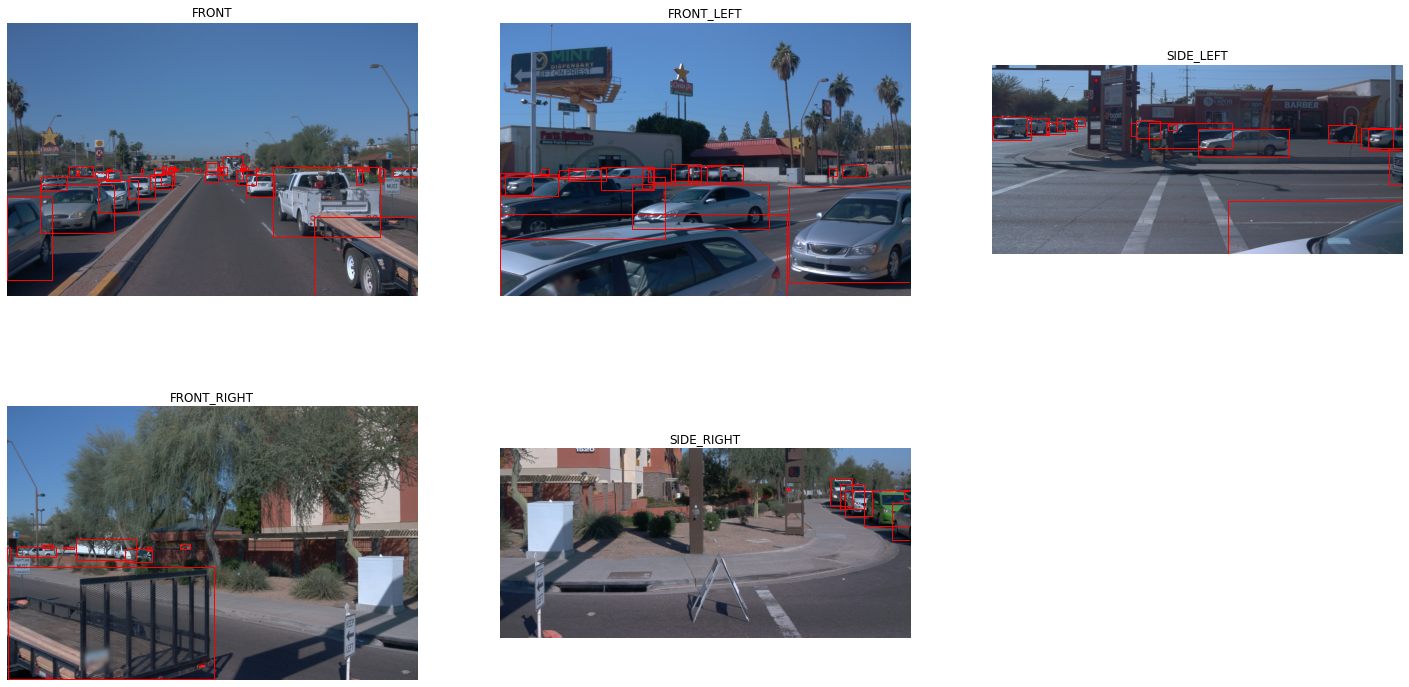

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_camera_image(camera_image, camera_labels, layout, cmap=None):
  """Show a camera image and the given camera labels."""

  ax = plt.subplot(*layout)

  # Draw the camera labels.
  for camera_labels in frame.camera_labels:
    # Ignore camera labels that do not correspond to this camera.
    if camera_labels.name != camera_image.name:
      continue

    # Iterate over the individual labels.
    for label in camera_labels.labels:
      # Draw the object bounding box.
      ax.add_patch(patches.Rectangle(
        xy=(label.box.center_x - 0.5 * label.box.length,
            label.box.center_y - 0.5 * label.box.width),
        width=label.box.length,
        height=label.box.width,
        linewidth=1,
        edgecolor='red',
        facecolor='none'))

  # Show the camera image.
  plt.imshow(tf.image.decode_jpeg(camera_image.image), cmap=cmap)
  plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
  plt.grid(False)
  plt.axis('off')

plt.figure(figsize=(25, 20))

for index, image in enumerate(frame.images):
  show_camera_image(image, frame.camera_labels, [3, 3, index+1])

##Visualize Range Images

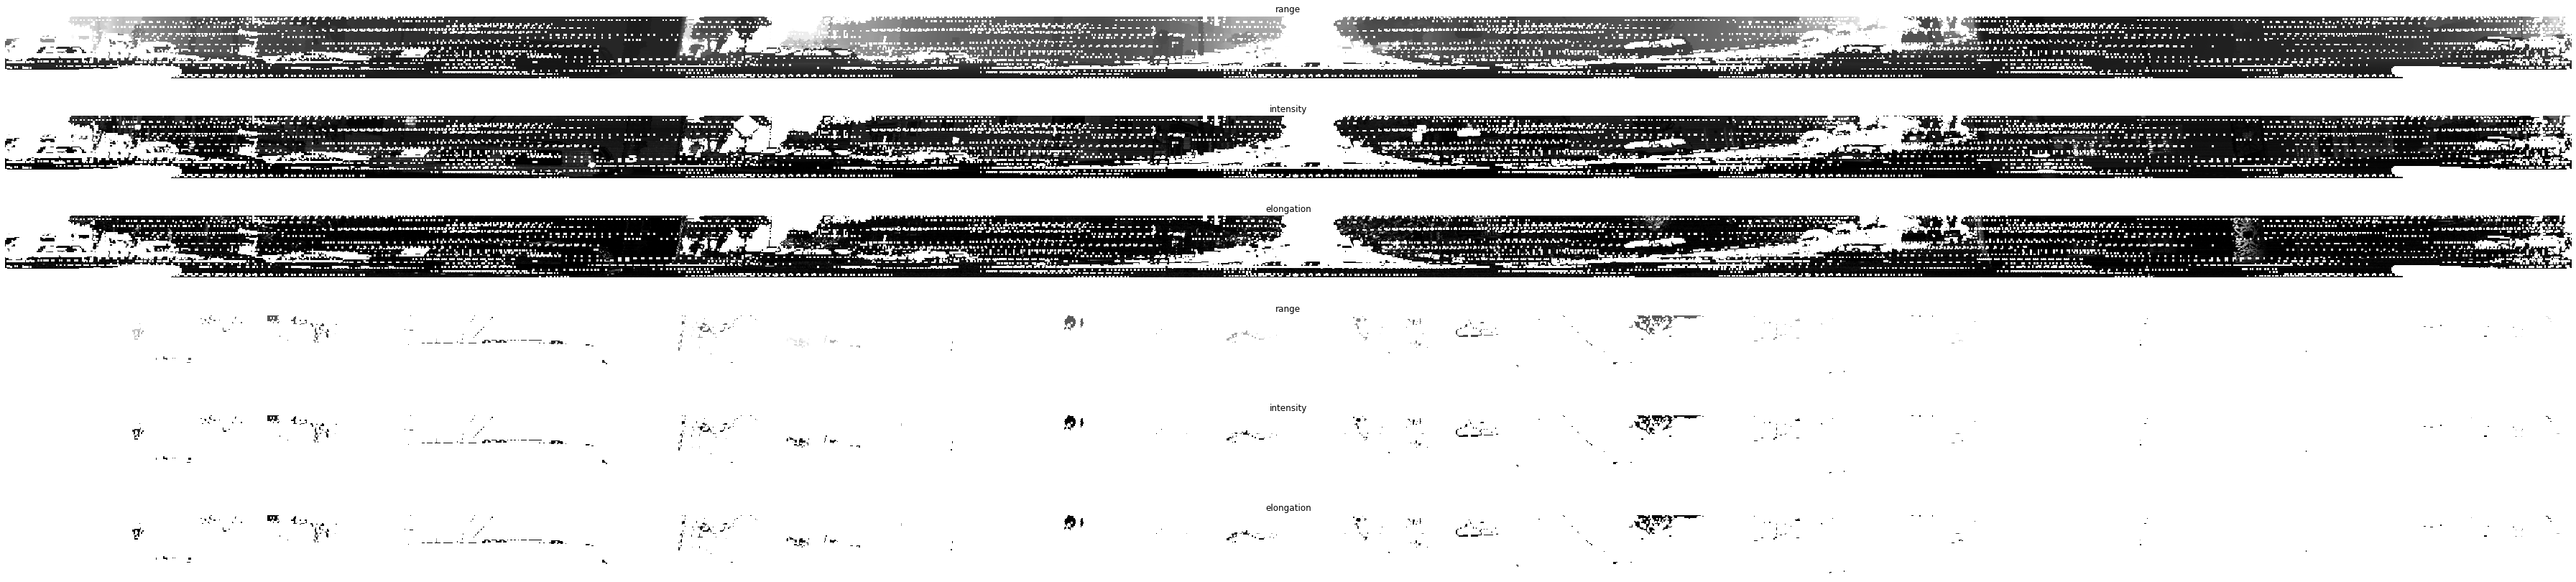

In [ ]:
plt.figure(figsize=(64, 20))
def plot_range_image_helper(data, name, layout, vmin = 0, vmax=1, cmap='gray'):
  """Plots range image.

  Args:
    data: range image data
    name: the image title
    layout: plt layout
    vmin: minimum value of the passed data
    vmax: maximum value of the passed data
    cmap: color map
  """
  plt.subplot(*layout)
  plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.title(name)
  plt.grid(False)
  plt.axis('off')

def get_range_image(laser_name, return_index):
  """Returns range image given a laser name and its return index."""
  return range_images[laser_name][return_index]

def show_range_image(range_image, layout_index_start = 1):
  """Shows range image.

  Args:
    range_image: the range image data from a given lidar of type MatrixFloat.
    layout_index_start: layout offset
  """
  range_image_tensor = tf.convert_to_tensor(range_image.data)
  range_image_tensor = tf.reshape(range_image_tensor, range_image.shape.dims)
  lidar_image_mask = tf.greater_equal(range_image_tensor, 0)
  range_image_tensor = tf.where(lidar_image_mask, range_image_tensor,
                                tf.ones_like(range_image_tensor) * 1e10)
  range_image_range = range_image_tensor[...,0] 
  range_image_intensity = range_image_tensor[...,1]
  range_image_elongation = range_image_tensor[...,2]
  plot_range_image_helper(range_image_range.numpy(), 'range',
                   [8, 1, layout_index_start], vmax=75, cmap='gray')
  plot_range_image_helper(range_image_intensity.numpy(), 'intensity',
                   [8, 1, layout_index_start + 1], vmax=1.5, cmap='gray')
  plot_range_image_helper(range_image_elongation.numpy(), 'elongation',
                   [8, 1, layout_index_start + 2], vmax=1.5, cmap='gray')
frame.lasers.sort(key=lambda laser: laser.name)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 0), 1)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 1), 4)

##Point Cloud Conversion and Visualization

In [ ]:
points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose)
points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose,
    ri_index=1)

# 3d points in vehicle frame.
points_all = np.concatenate(points, axis=0)
points_all_ri2 = np.concatenate(points_ri2, axis=0)
# camera projection corresponding to each point.
cp_points_all = np.concatenate(cp_points, axis=0)
cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)

###Examine number of points in each lidar sensor.

First return.

In [ ]:
print(points_all.shape)
print(cp_points_all.shape)
print(points_all[0:2])
for i in range(5):
  print(points[i].shape)
  print(cp_points[i].shape)

(156301, 3)
(156301, 6)
[[-61.389404   10.71875     4.6163807]
 [-61.46167    10.8828125   4.6200657]]
(141387, 3)
(141387, 6)
(2752, 3)
(2752, 6)
(3629, 3)
(3629, 6)
(3802, 3)
(3802, 6)
(4731, 3)
(4731, 6)


Second return.

In [ ]:
print(points_all_ri2.shape)
print(cp_points_all_ri2.shape)
print(points_all_ri2[0:2])
for i in range(5):
  print(points_ri2[i].shape)
  print(cp_points_ri2[i].shape)

(7100, 3)
(7100, 6)
[[-61.295288  12.080078   4.621109]
 [-64.32788   13.957031   4.74811 ]]
(6987, 3)
(6987, 6)
(6, 3)
(6, 6)
(32, 3)
(32, 6)
(23, 3)
(23, 6)
(52, 3)
(52, 6)


###Show point cloud
3D point clouds are rendered using an internal tool, which is unfortunately not publicly available yet. Here is an example of what they look like.

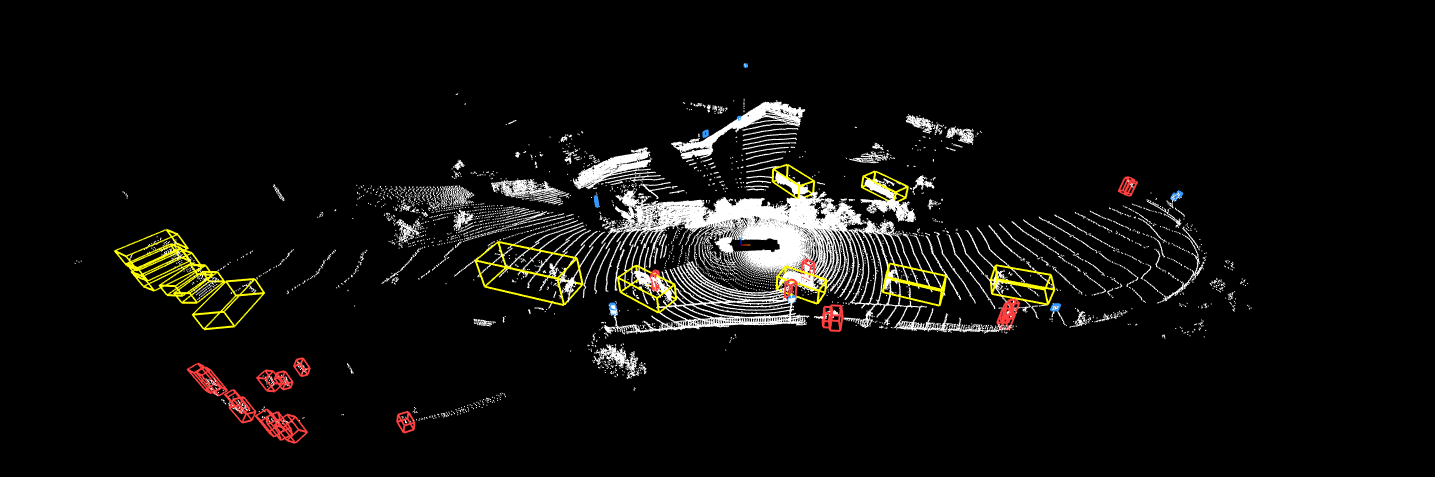

In [ ]:
from IPython.display import Image, display
display(Image('/content/waymo-od/tutorial/3d_point_cloud.png'))

##Visualize Camera Projection

In [ ]:
images = sorted(frame.images, key=lambda i:i.name)
cp_points_all_concat = np.concatenate([cp_points_all, points_all], axis=-1)
cp_points_all_concat_tensor = tf.constant(cp_points_all_concat)

# The distance between lidar points and vehicle frame origin.
points_all_tensor = tf.norm(points_all, axis=-1, keepdims=True)
cp_points_all_tensor = tf.constant(cp_points_all, dtype=tf.int32)

mask = tf.equal(cp_points_all_tensor[..., 0], images[0].name)

cp_points_all_tensor = tf.cast(tf.gather_nd(
    cp_points_all_tensor, tf.where(mask)), dtype=tf.float32)
points_all_tensor = tf.gather_nd(points_all_tensor, tf.where(mask))

projected_points_all_from_raw_data = tf.concat(
    [cp_points_all_tensor[..., 1:3], points_all_tensor], axis=-1).numpy()

In [ ]:
def rgba(r):
  """Generates a color based on range.

  Args:
    r: the range value of a given point.
  Returns:
    The color for a given range
  """
  c = plt.get_cmap('jet')((r % 20.0) / 20.0)
  c = list(c)
  c[-1] = 0.5  # alpha
  return c

def plot_image(camera_image):
  """Plot a cmaera image."""
  plt.figure(figsize=(20, 12))
  plt.imshow(tf.image.decode_jpeg(camera_image.image))
  plt.grid("off")

def plot_points_on_image(projected_points, camera_image, rgba_func,
                         point_size=5.0):
  """Plots points on a camera image.

  Args:
    projected_points: [N, 3] numpy array. The inner dims are
      [camera_x, camera_y, range].
    camera_image: jpeg encoded camera image.
    rgba_func: a function that generates a color from a range value.
    point_size: the point size.

  """
  plot_image(camera_image)

  xs = []
  ys = []
  colors = []

  for point in projected_points:
    xs.append(point[0])  # width, col
    ys.append(point[1])  # height, row
    colors.append(rgba_func(point[2]))

  plt.scatter(xs, ys, c=colors, s=point_size, edgecolors="none")

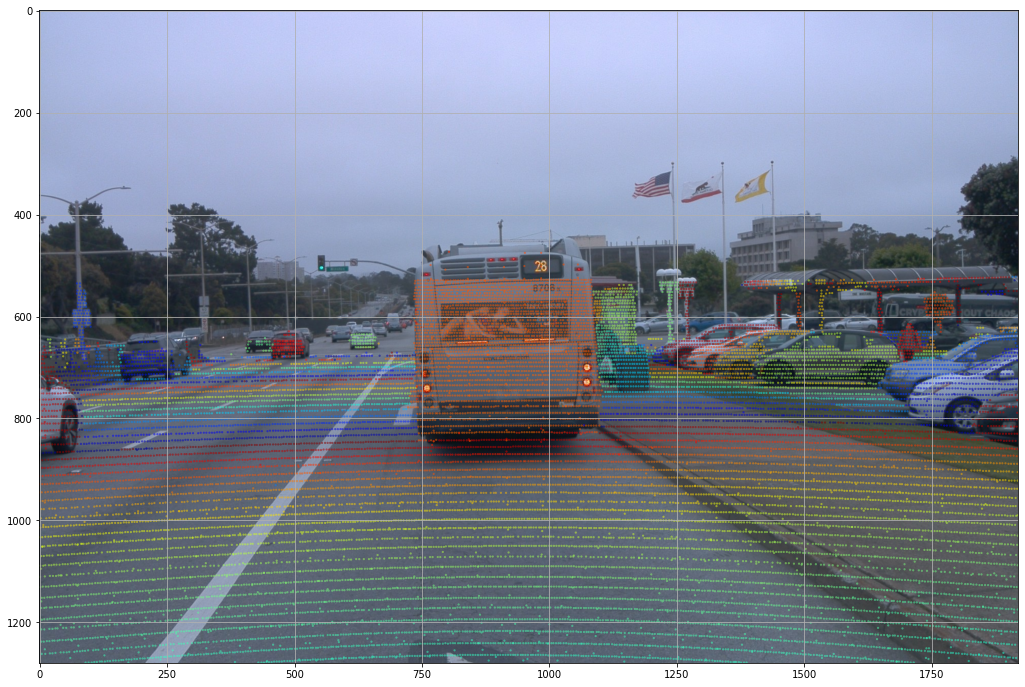

In [ ]:
plot_points_on_image(projected_points_all_from_raw_data,
                     images[0], rgba, point_size=5.0)

## Install from source code

The remaining part of this colab covers details of installing the repo form source code which provides a richer API.

### Install dependencies

In [ ]:
!sudo apt install build-essential
!sudo apt-get install --assume-yes pkg-config zip g++ zlib1g-dev unzip python3 python3-pip
!wget https://github.com/bazelbuild/bazel/releases/download/0.28.0/bazel-0.28.0-installer-linux-x86_64.sh
!sudo bash ./bazel-0.28.0-installer-linux-x86_64.sh

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
zip is already the newest version (3.0-11build1).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
g++ set to manually installed.
python3 is already the newest version (3.6.7-1~18.04).
python3 set to manually installed.
unzip is already the newest version (6.0-21ubuntu1.1).
The following additional packages will be installed:
  python-pip-whl python3-asn1crypto python3-cffi-backend python3-crypto
  python3-cryptography python3-idna python3-keyring python3-keyrings.alt
  python3-pkg-resources python3-secret

###Build and test (this can take 10 mins)

Configure .bazelrc. This works with/without Tensorflow. This colab machine has Tensorflow installed.

In [ ]:
!cd waymo-od && ./configure.sh && cat .bazelrc && bazel clean

In [ ]:
!cd waymo-od && bazel build ... --show_progress_rate_limit=10.0

### Metrics computation
The core metrics computation library is written in C++, so it can be extended to other programming languages. It can compute detection metrics (mAP) and tracking metrics (MOTA). See more information about the metrics on the [website](https://waymo.com/open/next/).

We provide command line tools and TensorFlow ops to call the detection metrics library to compute detection metrics. We will provide a similar wrapper for tracking metrics library in the future. You are welcome to contribute your wrappers.

#### Command line detection metrics computation

The command takes a pair of files for prediction and ground truth. Read the comment in waymo_open_dataset/metrics/tools/compute_detection_metrics_main.cc for details of the data format.

In [ ]:
!cd waymo-od && bazel-bin/waymo_open_dataset/metrics/tools/compute_detection_metrics_main waymo_open_dataset/metrics/tools/fake_predictions.bin  waymo_open_dataset/metrics/tools/fake_ground_truths.bin

#### TensorFlow custom op

A TensorFlow op is defined at metrics/ops/metrics_ops.cc. We provide a python wrapper of the op at metrics/ops/py_metrics_ops.py, and a tf.metrics-like implementation of the op at metrics/python/detection_metrics.py. This library requires TensorFlow to be installed.

Install TensorFlow and NumPy.

In [ ]:
!pip3 install numpy tensorflow

Reconfigure .bazelrc such that you can compile the TensorFlow ops

In [ ]:
!cd waymo-od && ./configure.sh && cat .bazelrc

Run the op and tf.metrics wrapper unit tests which can be referenced as example usage of the libraries.

In [ ]:
!cd waymo-od && bazel test waymo_open_dataset/metrics/ops/... && bazel test waymo_open_dataset/metrics/python/...

Run all tests in the repo.

In [ ]:
!cd waymo-od && bazel test ...

### Build local PIP package

In [ ]:
!cd waymo-od && export PYTHON_VERSION=3 && ./pip_pkg_scripts/build.sh

You can install the locally compiled package or access any c++ binary compiled from this.